# Dithering

It's a technique consisting on introducing deliberate noise (generated using an algorithm) into a signal.
In this notebook I will focus on images only.

## Floyd-Steinberg algorithm
It's an error-diffusing algorithm for dithering images. 

It distributes the quantization error of a specific pixel to its neighbours, by multiplying by the factors defined by the algorithm. 

The weight matrix is known as the kernel.

![Visual algorithm](https://cloudfront.codeproject.com/recipes/1001088/dithering-floyd-steinberg-diagram.png)

### Grayscale implementation

We just need to iterate over all pixels, approximate them to the nearest value of the color palette we choose, and apply the error to its neighbours.

We will not define the color palette by ourselves (Quantization will be uniform). We can find the nearest value by applying the uniform quantization formula for [0, 1] input and output range, since the pixels are already expressed as doubles in Octave.

H = 512
W = 512


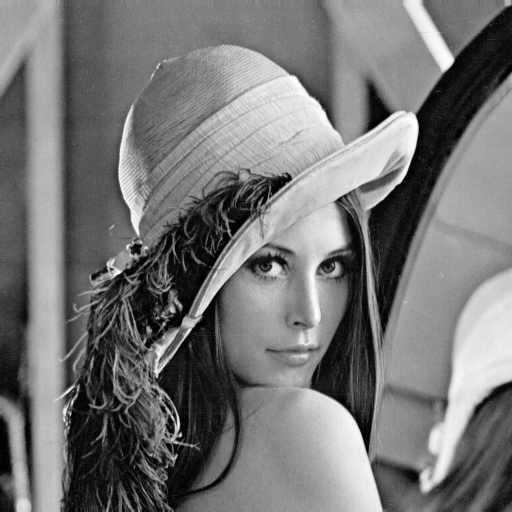

In [2]:
% Load the image as a HxWx3 vector of doubles [0, 1]
img = im2double(imread("lenna.jpg"));

% Convert to grayscale, HxW [0, 1]
img = rgb2gray(img);

% Height, Width
[H, W] = size(img)

imshow(img);

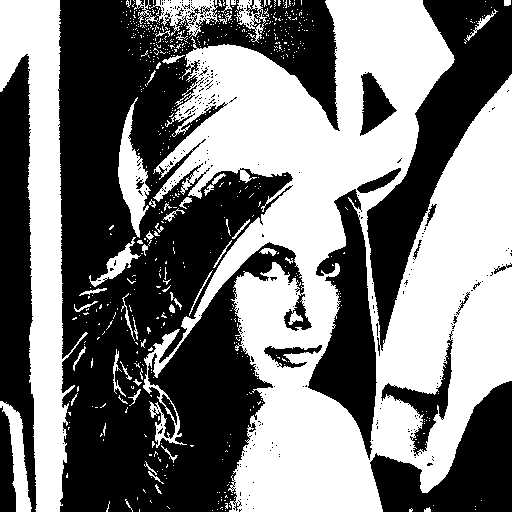

In [3]:
% Demo: only perform quantization without dithering

test_img = img; 

% Iterate from top to bottom row, left to right pixels
for y = 1:H,
  for x = 1:W, 
    % Read pixel value
    oldpixel = test_img(y, x);
    
    % Quantization: lesson 1 formula
    % Two levels = black and white (0, 1); Three levels = black, grey, white (0, 0.5, 1)...
    levels = 2;
    newpixel = round(oldpixel * (levels - 1)) / (levels - 1);
    
    % Replace pixel value
    test_img(y, x) = newpixel;
  endfor 
endfor

imwrite(test_img, "out/plain_grayscale.bmp");

imshow(test_img);

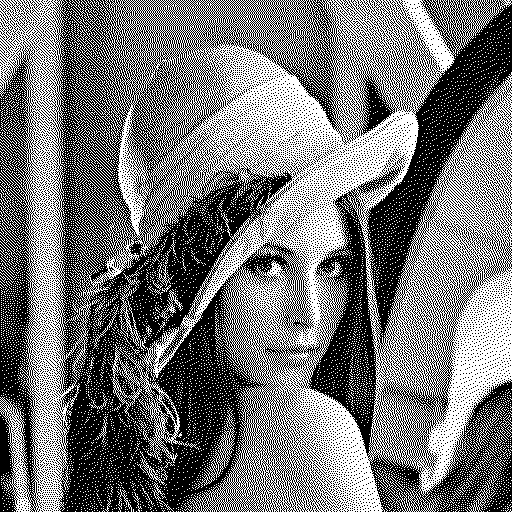

In [4]:
floyd_img = img; 

% Iterate from top to bottom row, left to right pixels
for y = 1:H,
  for x = 1:W, 
    % Read pixel value
    oldpixel = floyd_img(y, x);
    
    % Quantization: lesson 1 formula
    % Two levels = black and white (0, 1); Three levels = black, grey, white (0, 0.5, 1)...
    levels = 2;
    newpixel = round(oldpixel * (levels - 1)) / (levels - 1);
    
    % Quantization error
    error = oldpixel - newpixel;
    
    % Replace pixel value
    floyd_img(y, x) = newpixel;
    
    % Out of bounds error would happen when x=1, x=W or y=H
    if (x < W)
      floyd_img(y, x+1) += error * 7/16;
    endif 
    if (y < H)
      floyd_img(y+1, x) += error * 5/16;
    endif 
    if (x > 1 && y < H)
      floyd_img(y+1, x-1) += error * 3/16;
    endif 
    if (x < W && y < H)
      floyd_img(y+1, x+1) += error * 1/16;
    endif 
  endfor 
endfor

imwrite(floyd_img, "out/floyd_grayscale.bmp");

imshow(floyd_img);

## Jarvis, Judice and Ninke algorithm

Also known as minimized average error, the implementation is very similar to Floyd-Steinberg, only changing the kernel to diffuse error to pixels further away.

![Jarvis Judice Ninke kernel](https://wikimedia.org/api/rest_v1/media/math/render/svg/6745a860514efd85b6f9fc3e9b706a152d829be0)

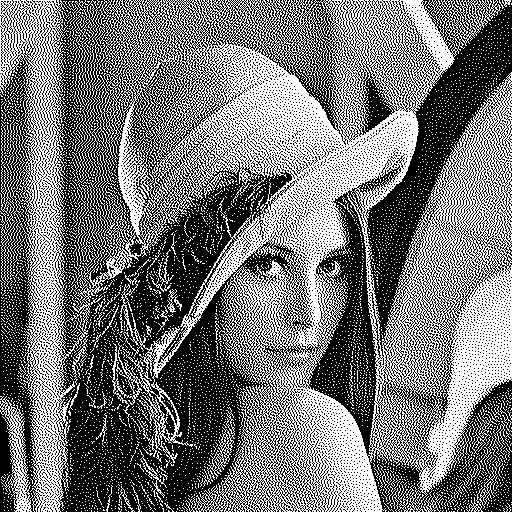

In [5]:
jarvis_img = img;

% Iterate from top to bottom row, left to right pixels
for y = 1:H,
  for x = 1:W,
    % Read pixel value
    oldpixel = jarvis_img(y, x);

    % Quantization: lesson 1 formula
    % Two levels = black and white (0, 1); Three levels = black, grey, white (0, 0.5, 1)...
    levels = 2;
    newpixel = round(oldpixel * (levels - 1)) / (levels - 1);

    % Quantization error
    error = oldpixel - newpixel;

    % Replace pixel value
    jarvis_img(y, x) = newpixel;

    % Out of bounds error would happen on pixels near the edges (range of two)
    if (x < W)
      jarvis_img(y, x+1) += error * 7/48;
    endif
    if (y < H)
      jarvis_img(y+1, x) += error * 7/48;
    endif
    if (x < W - 1)
      jarvis_img(y, x+2) += error * 5/48;
    endif
    if (x < W && y < H)
      jarvis_img(y+1, x+1) += error * 5/48;
    endif
    if (y < H - 1)
      jarvis_img(y+2, x) += error * 5/48;
    endif
    if (x > 1 && y < H)
      jarvis_img(y+1, x-1) += error * 5/48;
    endif
    if (x < W - 1 && y < H)
      jarvis_img(y+1, x+2) += error * 3/48;
    endif
    if (x < W && y < H - 1)
      jarvis_img(y+2, x+1) += error * 3/48;
    endif
    if (x > 1 && y < H - 1)
      jarvis_img(y+2, x-1) += error * 3/48;
    endif
    if (x > 2 && y < H)
      jarvis_img(y+1, x-2) += error * 3/48;
    endif
    if (x > 2 && y < H - 1)
      jarvis_img(y+2, x-2) += error * 1/48;
    endif
    if (x < W - 1 && y < H - 1)
      jarvis_img(y+2, x+2) += error * 1/48;
    endif
  endfor
endfor

imwrite(jarvis_img, "out/jarvis_grayscale.bmp");

imshow(jarvis_img);

## The illusion of color
The human eye can perceive colors not present in the image, by using a mixture of different colors. In the following example, we can see how purple can be perceived just by mixing red and blue, when the pixels get small enough.

![Dithering example](https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/Dithering_example_red_blue.svg/1280px-Dithering_example_red_blue.svg.png)

### Color implementation

For a more practical approach to dithering, we need to work with color images. There are many real life applications.

For example, it improves the experience of viewing an image on a color-restricted display such as e-ink. These screens can display seven colours at most, so dithering is of great utility for this case. 

![E-ink display](https://www.tinytronics.nl/image/cache/data/product-2965/WaveShare-5.65inch-SPI-E-Ink-E-Paper-7-Colors-7-Kleuren-600x448-Pixels-front-voorkant-600x600.JPG)

![Real example](https://i.ytimg.com/vi/daO46JaVHOs/hq720.jpg?sqp=-oaymwEhCK4FEIIDSFryq4qpAxMIARUAAAAAGAElAADIQj0AgKJD&rs=AOn4CLCULs0tY0Fyo2iyOr-_P5JJT27RTA)

As we can see, the perceived color range is much bigger than the actual color palette of the screen.

We can also see the characteristical dots, grain of sand effect, introduced by dithering.

In color images it is more useful to provide a custom color palette (quantization will be non-uniform).

To implement any of the algorithms for color images, we need to define a method of finding the closest color in our palette for each pixel (i.e. measuring distance between colors).

For this we can measure the distance between points on a 3D space. As human color perception changes do not match the RGB color space changes, we shall perform the color comparisons using the L\*a\*b\* colorspace which better represents our perception of distance between colors.

This colorspace is available on the image package.

In [6]:
% if not installed: 
% pkg install image

pkg load image
graphics_toolkit("gnuplot")


The gnuplot graphics toolkit is not actively maintained and has a number
of limitations that are unlikely to be fixed.  Communication with gnuplot
uses a one-directional pipe and limited information is passed back to the
Octave interpreter so most changes made interactively in the plot window
will not be reflected in the graphics properties managed by Octave.  For
example, if the plot window is closed with a mouse click, Octave will not
be notified and will not update its internal list of open figure windows.
The qt toolkit is recommended instead.


H = 512
W = 512


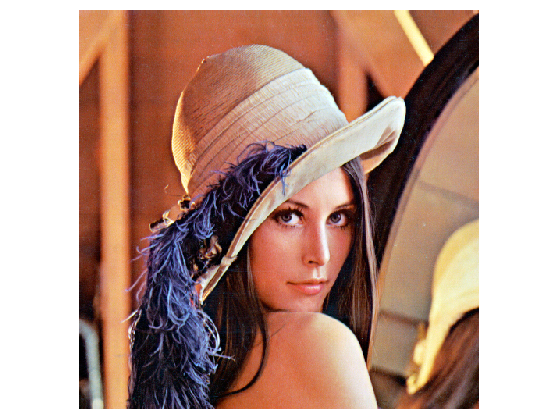

In [7]:
% Load the image as a HxWx3 vector of doubles [0, 1]
colorimg = im2double(imread("lenna.jpg"));

% Height, Width
[H, W, ~] = size(colorimg)

imshow(colorimg);

Note that we need to define a function to find the closest color in our palette. As the palette I will use the colors from the ACeP e-ink display shown before.

In [8]:
function palette_color = find_closest_palette_color(original_color)
% Extracted from ACeP library
  color_list_rgb = [
    0 0 0 % black
    255 255 255 % white
    67 138 28 % green
    100 64 255 % blue/purple
    191 0 0 % red
    255 243 56 % yellow
    232 126 0 % orange
  ];
  
  color_list = rgb2lab(double(color_list_rgb / 255));

  % Convert all needed values to L*a*b*
  distance_list = color_list - original_color;

  % For each (l, a, b) row, calculate l^2 + a^2 + b^2
  % We only want to compare the distances, not calculate the value, so no need to take the square root
  distances = sum(distance_list.^2, 2);

  [~, min_index] = min(distances);
  palette_color = color_list(min_index, :);

endfunction

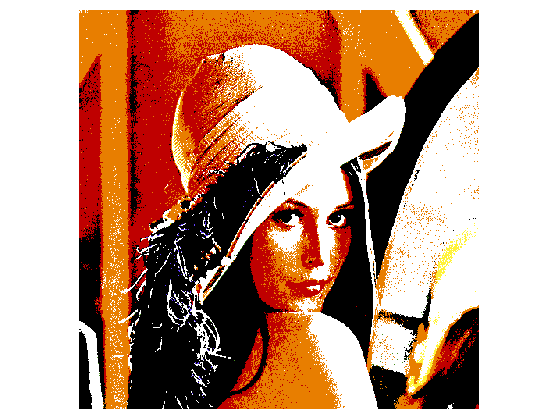

In [9]:
% Demo: only perform quantization without dithering

test_img = rgb2lab(colorimg); 

% Iterate from top to bottom row, left to right pixels
for y = 1:H,
  for x = 1:W, 
    % Read pixel value
    oldpixel = reshape(test_img(y, x, :), 1, 3);

    newpixel = find_closest_palette_color(oldpixel);
    
    % Replace pixel value
    test_img(y, x, :) = newpixel;
  endfor 
endfor

test_img = lab2rgb(test_img);

imwrite(test_img, "out/plain_color.bmp");

imshow(test_img);

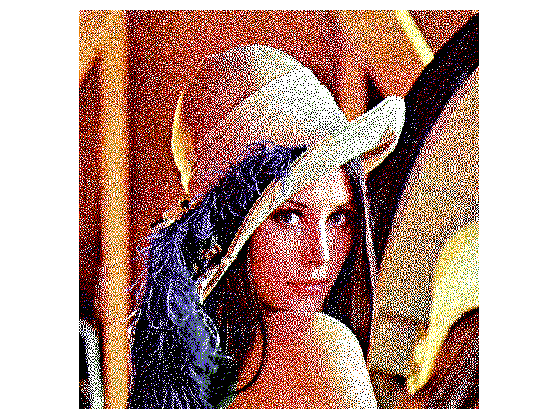

In [10]:
% We work in the L*a*b* color space
floyd_img = rgb2lab(colorimg);

% Iterate from top to bottom row, left to right pixels
for y = 1:H,
  for x = 1:W,
    % Read pixel value
    oldpixel = reshape(floyd_img(y, x, :), 1, 3);

    newpixel = find_closest_palette_color(oldpixel);

    % Quantization error
    error = oldpixel - newpixel;

    % Replace pixel value
    floyd_img(y, x, :) = newpixel;

    % Out of bounds error would happen when x=1, x=W or y=H
    if (x < W)
      floyd_img(y, x+1, :) += reshape(error * 7/16, 1, 1, 3);
    endif
    if (y < H)
      floyd_img(y+1, x, :) += reshape(error * 5/16, 1, 1, 3);
    endif
    if (x > 1 && y < H)
      floyd_img(y+1, x-1, :) += reshape(error * 3/16, 1, 1, 3);
    endif
    if (x < W && y < H)
      floyd_img(y+1, x+1, :) += reshape(error * 1/16, 1, 1, 3);
    endif
  endfor
endfor

% Convert back to RGB for display
floyd_img = lab2rgb(floyd_img);

imwrite(floyd_img, "out/floyd_color.bmp");

imshow(floyd_img);

The only notable changes from the grayscale algorithm is the usage of the reshape function, to allow changing the data structures to more manageable forms; and the aforementioned helper function to find palette matches, in place of the uniform quantization that we previously used on grayscale examples.

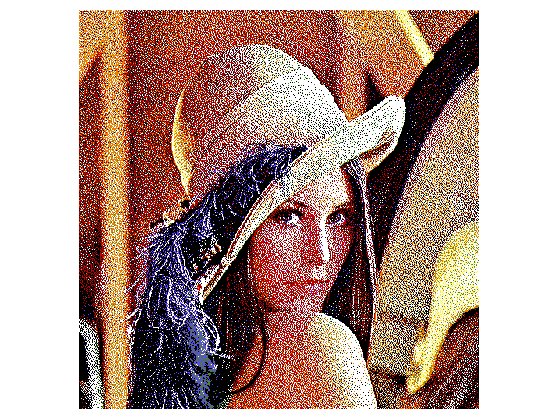

In [11]:
% We work in the L*a*b* color space
jarvis_img = rgb2lab(colorimg);

% Iterate from top to bottom row, left to right pixels
for y = 1:H,
  for x = 1:W,
    % Read pixel value
    oldpixel = reshape(jarvis_img(y, x, :), 1, 3);

    newpixel = find_closest_palette_color(oldpixel);

    % Quantization error
    error = oldpixel - newpixel;

    % Replace pixel value
    jarvis_img(y, x, :) = newpixel;

    % Out of bounds error would happen on pixels near the edges (range of two)
    if (x < W)
      jarvis_img(y, x+1, :) += reshape(error * 7/48, 1, 1, 3);
    endif
    if (y < H)
      jarvis_img(y+1, x, :) += reshape(error * 7/48, 1, 1, 3);
    endif
    if (x < W - 1)
      jarvis_img(y, x+2, :) += reshape(error * 5/48, 1, 1, 3);
    endif
    if (x < W && y < H)
      jarvis_img(y+1, x+1, :) += reshape(error * 5/48, 1, 1, 3);
    endif
    if (y < H - 1)
      jarvis_img(y+2, x, :) += reshape(error * 5/48, 1, 1, 3);
    endif
    if (x > 1 && y < H)
      jarvis_img(y+1, x-1, :) += reshape(error * 5/48, 1, 1, 3);
    endif
    if (x < W - 1 && y < H)
      jarvis_img(y+1, x+2, :) += reshape(error * 3/48, 1, 1, 3);
    endif
    if (x < W && y < H - 1)
      jarvis_img(y+2, x+1, :) += reshape(error * 3/48, 1, 1, 3);
    endif
    if (x > 1 && y < H - 1)
      jarvis_img(y+2, x-1, :) += reshape(error * 3/48, 1, 1, 3);
    endif
    if (x > 2 && y < H)
      jarvis_img(y+1, x-2, :) += reshape(error * 3/48, 1, 1, 3);
    endif
    if (x > 2 && y < H - 1)
      jarvis_img(y+2, x-2, :) += reshape(error * 1/48, 1, 1, 3);
    endif
    if (x < W - 1 && y < H - 1)
      jarvis_img(y+2, x+2, :) += reshape(error * 1/48, 1, 1, 3);
    endif
  endfor
endfor

% Convert back to RGB for display
jarvis_img = lab2rgb(jarvis_img);

imwrite(jarvis_img, "out/jarvis_color.bmp");

imshow(jarvis_img);

As a test, now I'm gonna try to perform the same example by working on the RGB colorspace. The comparison is still done on the CIELAB color space, but error diffusion is done on RGB.

In [12]:
function palette_color = find_closest_palette_color(original_color_rgb)
% Extracted from ACeP library
  color_list_rgb = [
    0 0 0 % black
    255 255 255 % white
    67 138 28 % green
    100 64 255 % blue/purple
    191 0 0 % red
    255 243 56 % yellow
    232 126 0 % orange
  ];

  % Map to [0, 1] range
  color_list_rgb = double(color_list_rgb / 255);

  % Convert all colors to L*a*b*
  distance_list = rgb2lab(color_list_rgb) - rgb2lab(original_color_rgb);

  % For each (l, a, b) row, calculate l^2 + a^2 + b^2
  % We only want to compare the distances, not calculate the value, so no need to take the square root
  distances = sum(distance_list.^2, 2);

  [~, min_index] = min(distances);

  % Return the RGB value of the closest color
  palette_color = color_list_rgb(min_index, :);

endfunction

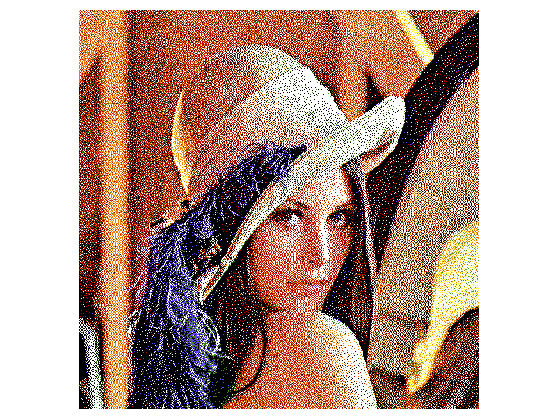

In [13]:
% Now we work in the RGB color space
floyd_img = colorimg;

% Iterate from top to bottom row, left to right pixels
for y = 1:H,
  for x = 1:W,
    % Read pixel value
    oldpixel = reshape(floyd_img(y, x, :), 1, 3);

    newpixel = find_closest_palette_color(oldpixel);

    % Quantization error
    error = oldpixel - newpixel;

    % Replace pixel value
    floyd_img(y, x, :) = newpixel;

    % Out of bounds error would happen when x=1, x=W or y=H
    if (x < W)
      floyd_img(y, x+1, :) += reshape(error * 7/16, 1, 1, 3);
    endif
    if (y < H)
      floyd_img(y+1, x, :) += reshape(error * 5/16, 1, 1, 3);
    endif
    if (x > 1 && y < H)
      floyd_img(y+1, x-1, :) += reshape(error * 3/16, 1, 1, 3);
    endif
    if (x < W && y < H)
      floyd_img(y+1, x+1, :) += reshape(error * 1/16, 1, 1, 3);
    endif
  endfor
endfor

imwrite(floyd_img, "out/floyd_color_lab_comparison.bmp");

imshow(floyd_img);

And lastly, the easy approach: performing the entire process in the RGB colorspace. This should worsen the color accuracy of the output.

In [14]:
function palette_color = find_closest_palette_color(original_color_rgb)
% Extracted from ACeP library
  color_list_rgb = [
    0 0 0 % black
    255 255 255 % white
    67 138 28 % green
    100 64 255 % blue/purple
    191 0 0 % red
    255 243 56 % yellow
    232 126 0 % orange
  ];

  % Map to [0, 1] range
  color_list_rgb = double(color_list_rgb / 255);

  % Calculate distance in RGB
  distance_list = color_list_rgb - original_color_rgb;

  % For each (r, g, b) row, calculate r^2 + g^2 + b^2
  % We only want to compare the distances, not calculate the value, so no need to take the square root
  distances = sum(distance_list.^2, 2);

  [~, min_index] = min(distances);

  % Return the RGB value of the closest color
  palette_color = color_list_rgb(min_index, :);

endfunction

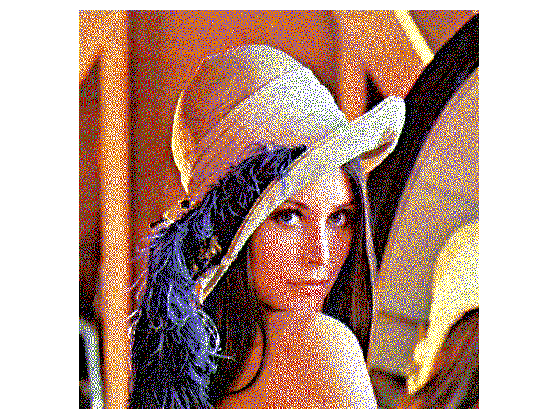

In [15]:
% Now we work in the RGB color space
floyd_img = colorimg;

% Iterate from top to bottom row, left to right pixels
for y = 1:H,
  for x = 1:W,
    % Read pixel value
    oldpixel = reshape(floyd_img(y, x, :), 1, 3);

    newpixel = find_closest_palette_color(oldpixel);

    % Quantization error
    error = oldpixel - newpixel;

    % Replace pixel value
    floyd_img(y, x, :) = newpixel;

    % Out of bounds error would happen when x=1, x=W or y=H
    if (x < W)
      floyd_img(y, x+1, :) += reshape(error * 7/16, 1, 1, 3);
    endif
    if (y < H)
      floyd_img(y+1, x, :) += reshape(error * 5/16, 1, 1, 3);
    endif
    if (x > 1 && y < H)
      floyd_img(y+1, x-1, :) += reshape(error * 3/16, 1, 1, 3);
    endif
    if (x < W && y < H)
      floyd_img(y+1, x+1, :) += reshape(error * 1/16, 1, 1, 3);
    endif
  endfor
endfor

imwrite(floyd_img, "out/floyd_color_rgb.bmp");

imshow(floyd_img);

## Sources

Dobres, Jonathan. "The unreasonable effectiveness of dithering". https://jdobr.es/blog/dithering

Wikipedia. Dithering page. https://en.wikipedia.org/wiki/Dither

Universidad de Granada. Standard grayscale test images. https://ccia.ugr.es/cvg/CG/base.htm

Waveshare. 5.65inch e-Paper Module (F) Manual. https://www.waveshare.com/wiki/5.65inch_e-Paper_Module_(F)_Manual#Overview